In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
import glob
import re
import itertools
import time
import joblib
import random
import itertools

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
pd.options.display.precision = 3
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import matplotlib.pyplot as plt
from matplotlib import container
from matplotlib.lines import Line2D

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.85

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly', 'mapsplice2']

In [8]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [9]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [10]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [11]:
start = time.time()
x_train, y_train = apps.assemble_data(training_samples, callers, out_dir)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 80.6s


fit models in 315.5s


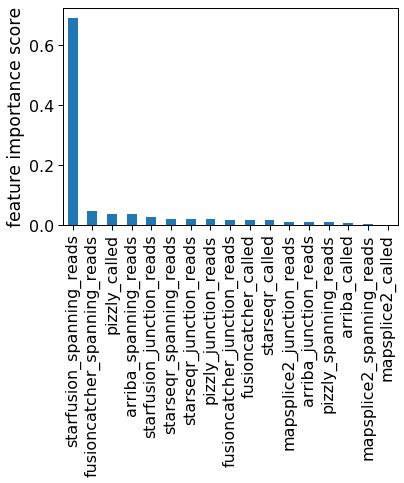

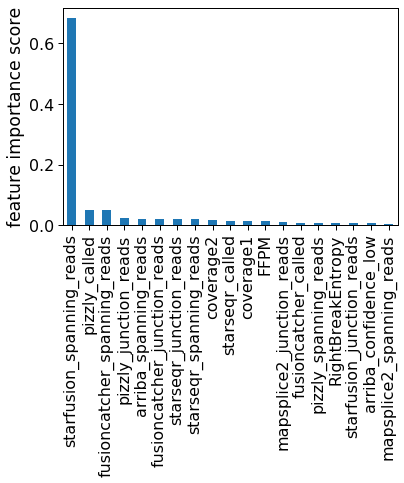

In [15]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

base_columns = []
for c in callers:
    base_columns += [c + '_called', c + '_spanning_reads', c + '_junction_reads']
base_columns.remove('starfusion_called')
optimized_features = [
    'starseqr_called', 'starseqr_spanning_reads', 'starseqr_junction_reads',
    'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads',
    'fusioncatcher_called', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads',
    'pizzly_called', 'pizzly_spanning_reads', 'pizzly_junction_reads', 'mapsplice2_spanning_reads',
    'mapsplice2_junction_reads', 'FFPM', 'RightBreakEntropy', 'coverage1', 'coverage2', 'arriba_confidence_low'
]
classifiers = []
for features in [
            base_columns,
            optimized_features
        ]:
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]


    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]
    
    #label = 'RFC{}F'.format(len(features))
    #trans = 'noop'
    #classifier = ensemble.RandomForestClassifier()
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]
    
    plt.figure()
    feature_importances = pd.Series(classifier.feature_importances_, features).sort_values(ascending=False)
    feature_importances.plot(kind='bar')
    plt.ylabel('feature importance score')

    label = 'DefaultGBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]
    

print('fit models in {:.1f}s'.format((time.time() - start)))

In [16]:
x_train.shape, len(y_train), sum(y_train)

((64116, 30), 64116, 34000)

In [17]:
start = time.time()
consensus_data = pd.read_hdf(
    apps.predict_consensus(testing_samples, out_dir, callers, [3, 4, 5, 6, 7]), 'data'
)
print('assembled consensus predictions in {:.1f}s'.format((time.time() - start)))

start = time.time()
consensus = ['ConsensusQ5', 'ConsensusQ4', 'ConsensusQ3']
model_data = pd.read_hdf(
    apps.predict(testing_samples, out_dir, classifiers, callers, consensus=consensus), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled consensus predictions in 10.5s
assembled predictions in 100.7s


In [18]:
model_data.caller.unique()

array(['PolyfuseGBC17F', 'ConsensusQ5PolyfuseGBC17F',
       'ConsensusQ4PolyfuseGBC17F', 'ConsensusQ3PolyfuseGBC17F',
       'PolyfuseDefaultGBC17F', 'ConsensusQ5PolyfuseDefaultGBC17F',
       'ConsensusQ4PolyfuseDefaultGBC17F',
       'ConsensusQ3PolyfuseDefaultGBC17F', 'PolyfuseGBC19F',
       'ConsensusQ5PolyfuseGBC19F', 'ConsensusQ4PolyfuseGBC19F',
       'ConsensusQ3PolyfuseGBC19F', 'PolyfuseDefaultGBC19F',
       'ConsensusQ5PolyfuseDefaultGBC19F',
       'ConsensusQ4PolyfuseDefaultGBC19F',
       'ConsensusQ3PolyfuseDefaultGBC19F'], dtype=object)

In [19]:
summary = apps.make_summary(out_dir, testing_samples)

In [20]:
summary = summary[summary['sample'] != 'LIB-04648wt']

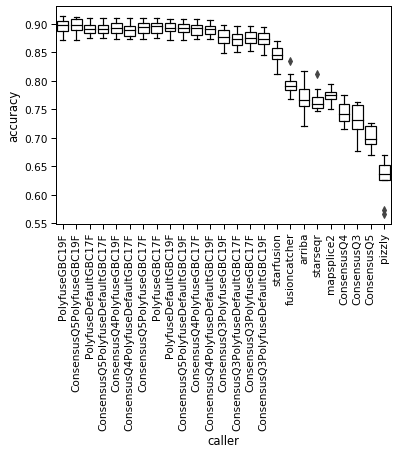

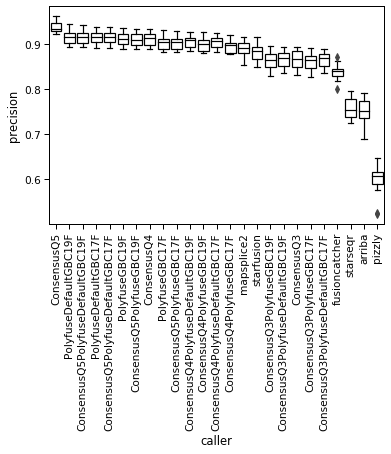

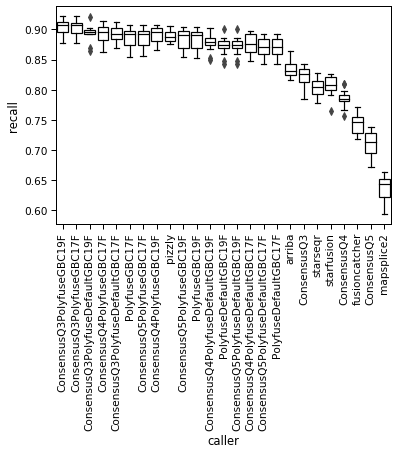

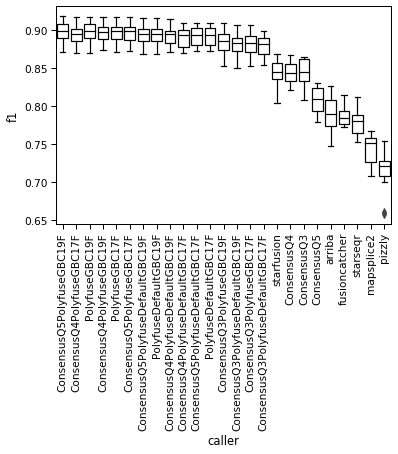

In [22]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    #plt.figure(figsize=(8, 7))
    plt.figure()
    #sorted_index = summary[metric].median().sort_values().index
    #print(sorted_index)
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

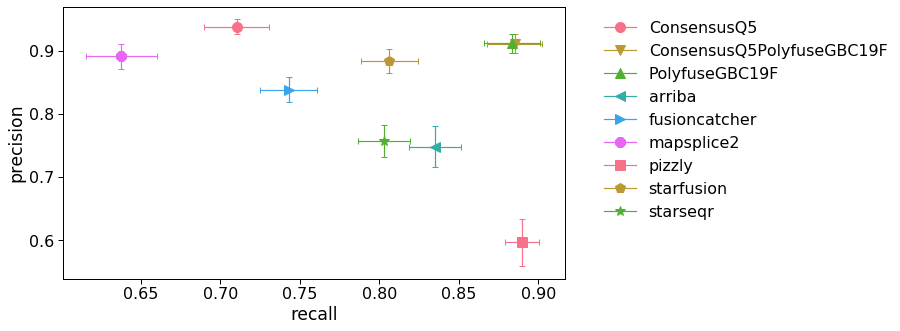

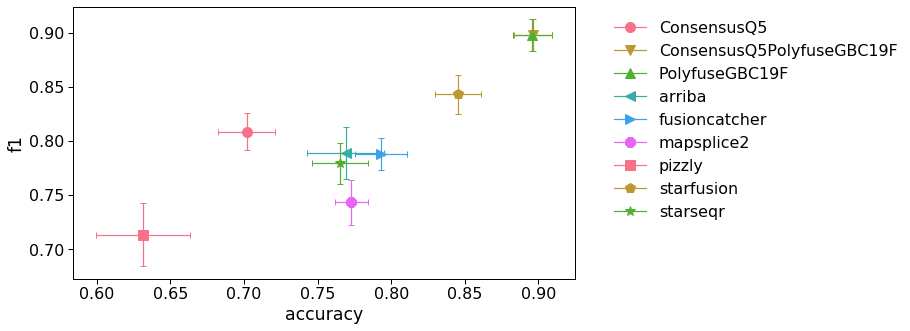

In [44]:
sns.set_context('paper', font_scale=1.8)
filter_regex = 'PolyfuseDefaultGBC17F|PolyfuseDefaultGBC19F|PolyfuseGBC17F|ConsensusQ3|ConsensusQ4'
top_model_summary = summary[~summary.caller.str.contains(filter_regex)]
means = top_model_summary.groupby('caller').mean()
stds = top_model_summary.groupby('caller').std()

#markers = itertools.cycle(Line2D.filled_markers)
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'D'))
markers = itertools.cycle(Line2D.filled_markers[:len(means)])
sns.set_palette(sns.diverging_palette(145, 280, s=85, l=25, n=8, center='dark'))
sns.set_palette(sns.diverging_palette(10, 220, sep=80, n=9, center='dark'))
sns.set_palette("husl")

for x, y in [('recall', 'precision'), ('accuracy', 'f1')]:
    fig, ax = plt.subplots(figsize=(9, 5))

    for caller in means.index:
        plt.errorbar(
            [means.loc[caller][x]],
            [means.loc[caller][y]],
            xerr=stds.loc[caller][x],
            yerr=stds.loc[caller][y],
            label=caller,
            marker=next(markers),
            markersize=10,
            capsize=3
        )
        
    plt.xlabel(x)
    plt.ylabel(y)
    handles, labels = ax.get_legend_handles_labels()
    handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), frameon=False)
    #plt.tight_layout()
    plt.savefig('plots/{}_vs_{}.pdf'.format(x, y))
    

In [242]:
pd.options.display.max_rows = None
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
ConsensusQ5PolyfuseGBC19F,439.333,43.083,60.667,426.917,0.879,0.911,0.893,0.894,0.786
PolyfuseGBC19F,438.667,42.667,61.333,427.333,0.877,0.911,0.893,0.894,0.786
PolyfuseGBC17F,441.083,45.667,58.917,424.333,0.882,0.906,0.892,0.894,0.784
ConsensusQ5PolyfuseGBC17F,441.750,46.417,58.250,423.583,0.884,0.905,0.892,0.894,0.784
PolyfuseDefaultGBC17F,438.500,44.167,61.500,425.833,0.877,0.909,0.891,0.892,0.782
ConsensusQ5PolyfuseDefaultGBC17F,438.500,44.333,61.500,425.667,0.877,0.908,0.891,0.892,0.782
ConsensusQ4PolyfuseGBC17F,445.250,51.500,54.750,418.500,0.890,0.897,0.891,0.893,0.780
ConsensusQ4PolyfuseGBC19F,443.333,49.833,56.667,420.167,0.887,0.899,0.890,0.893,0.780
ConsensusQ4PolyfuseDefaultGBC17F,440.833,48.750,59.167,421.250,0.882,0.901,0.889,0.891,0.777


In [220]:
pd.options.display.max_rows = None
summary.sort_values(by='accuracy', ascending=False)

,sample,caller,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
61,LIB-04650wt,ConsensusQ5PolyfuseGBC19F,449,43,51,520,0.898,0.913,0.912,0.905,0.822
49,LIB-04650wt,PolyfuseGBC19F,448,42,52,521,0.896,0.914,0.912,0.905,0.822
68,LIB-04657wt,ConsensusQ5PolyfuseGBC19F,450,31,50,362,0.900,0.936,0.909,0.917,0.818
4,LIB-04653wt,PolyfuseGBC17F,440,27,60,428,0.880,0.942,0.909,0.910,0.820
56,LIB-04657wt,PolyfuseGBC19F,449,31,51,362,0.898,0.935,0.908,0.916,0.816
20,LIB-04657wt,ConsensusQ5PolyfuseGBC17F,452,34,48,359,0.904,0.930,0.908,0.917,0.815
8,LIB-04657wt,PolyfuseGBC17F,452,34,48,359,0.904,0.930,0.908,0.917,0.815
13,LIB-04650wt,ConsensusQ5PolyfuseGBC17F,451,49,49,514,0.902,0.902,0.908,0.902,0.815
25,LIB-04650wt,PolyfuseDefaultGBC17F,448,46,52,517,0.896,0.907,0.908,0.901,0.815
37,LIB-04650wt,ConsensusQ5PolyfuseDefaultGBC17F,448,46,52,517,0.896,0.907,0.908,0.901,0.815


PolyfuseRFC10F
PolyfuseGBC10F
PolyfuseDefaultGBC10F
PolyfuseRFC15F
PolyfuseGBC15F
PolyfuseDefaultGBC15F


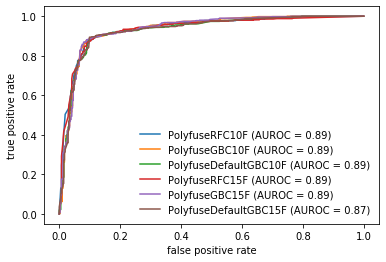

In [77]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

PolyfuseRFC4F
PolyfuseGBC4F
PolyfuseDefaultGBC4F
PolyfuseRFC7F
PolyfuseGBC7F
PolyfuseDefaultGBC7F


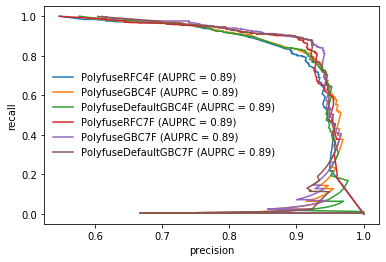

In [27]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [21]:
from sklearn.feature_selection import RFECV
#classifier = joblib.load(os.path.join(out_dir, 'models/GBC22F.joblib'))
start = time.time()
classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=1250, subsample=1.)
classifier.fit(x_train, y_train)


cv_selector = RFECV(classifier, cv=5, step=1, scoring='recall', n_jobs=-1)
cv_selector = cv_selector.fit(x_train, y_train)
                         
rfecv_features = [feature for support, feature in zip(cv_selector.get_support(), x_train.columns) if support]
print('Optimal number of features:', cv_selector.n_features_)
print('Best features:', rfecv_features)


Optimal number of features: 19
Best features: ['starseqr_called', 'starseqr_spanning_reads', 'starseqr_junction_reads', 'starfusion_spanning_reads', 'starfusion_junction_reads', 'arriba_spanning_reads', 'fusioncatcher_called', 'fusioncatcher_spanning_reads', 'fusioncatcher_junction_reads', 'pizzly_called', 'pizzly_spanning_reads', 'pizzly_junction_reads', 'mapsplice2_spanning_reads', 'mapsplice2_junction_reads', 'FFPM', 'RightBreakEntropy', 'coverage1', 'coverage2', 'arriba_confidence_low']


NameError: name 'cv_estimator' is not defined

<Figure size 576x576 with 0 Axes>

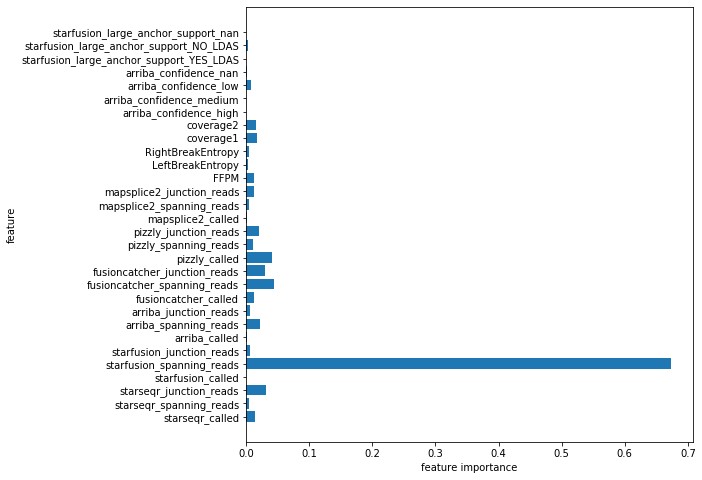

calculated best features in 3502.6s


In [22]:
n_features = x_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), classifier.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), x_train.columns.values) 
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()
print('calculated best features in {:.1f}s'.format(time.time() - start))

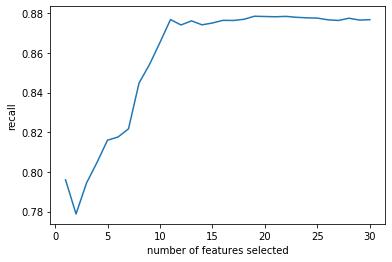

In [60]:
plt.figure()
plt.xlabel("number of features selected")
plt.ylabel("recall")
plt.plot(range(1, len(cv_selector.grid_scores_) + 1), cv_selector.grid_scores_)
plt.show()

In [ ]:
start = time.time()
cv_selector = RFECV(classifier, cv=5, step=1, scoring='accuracy', n_jobs=-1)
cv_selector = cv_selector.fit(x_train, y_train)
                         
rfecv_features = [feature for support, feature in zip(cv_selector.get_support(), x_train.columns) if support]
print('Optimal number of features:', cv_selector.n_features_)
print('Best features:', rfecv_features)
n_features = x_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), x_train.columns.values) 
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()
print('calculated best features in {:.1f}s'.format(time.time() - start))

In [52]:
x_train

,FFPM,LargeAnchorSupport,LeftBreakEntropy,RightBreakEntropy,arriba_called,arriba_confidence_high,arriba_confidence_low,arriba_confidence_medium,arriba_confidence_nan,arriba_junction_reads,arriba_spanning_reads,confidence,coverage1,coverage2,fusioncatcher_called,fusioncatcher_junction_reads,fusioncatcher_spanning_reads,mapsplice2_called,mapsplice2_junction_reads,mapsplice2_spanning_reads,pizzly_called,pizzly_junction_reads,pizzly_spanning_reads,starfusion_called,starfusion_junction_reads,starfusion_large_anchor_support_NO_LDAS,starfusion_large_anchor_support_YES_LDAS,starfusion_large_anchor_support_nan,starfusion_spanning_reads,starseqr_called,starseqr_junction_reads,starseqr_spanning_reads
0,0.800,NaN,1.690,1.832,1,1.0,0.0,0.0,0.0,6.0,19.0,NaN,51.0,27.0,1,5.0,19.0,1,7.0,22.0,1,13.0,2.0,1,5.0,0.0,1.0,0.0,19.0,1,6.0,19.0
1,0.000,NaN,0.000,0.000,1,1.0,0.0,0.0,0.0,6.0,47.0,NaN,181.0,34.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
2,21.900,NaN,1.933,1.933,1,1.0,0.0,0.0,0.0,126.0,300.0,NaN,2038.0,655.0,1,25.0,457.0,1,304.0,778.0,1,407.0,130.0,1,153.0,0.0,1.0,0.0,504.0,1,137.0,429.0
3,5.000,NaN,1.966,1.889,1,1.0,0.0,0.0,0.0,23.0,113.0,NaN,129.0,113.0,1,19.0,114.0,1,38.0,210.0,1,104.0,28.0,1,24.0,0.0,1.0,0.0,126.0,1,22.0,125.0
4,90.833,NaN,1.922,1.829,1,1.0,0.0,0.0,0.0,420.0,300.0,NaN,1534.0,1530.0,1,25.0,2040.0,1,1086.0,3248.0,1,1777.0,472.0,1,647.0,0.0,1.0,0.0,2078.0,1,425.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,1,19.0,81.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1008,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,714.0,241.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1009,0.000,NaN,0.000,0.000,1,1.0,0.0,0.0,0.0,8.0,26.0,NaN,92.0,33.0,0,0.0,0.0,0,0.0,0.0,1,24.0,10.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1010,0.000,NaN,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,136.0,37.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0


In [54]:
x_train.fillna(0)

,FFPM,LargeAnchorSupport,LeftBreakEntropy,RightBreakEntropy,arriba_called,arriba_confidence_high,arriba_confidence_low,arriba_confidence_medium,arriba_confidence_nan,arriba_junction_reads,arriba_spanning_reads,confidence,coverage1,coverage2,fusioncatcher_called,fusioncatcher_junction_reads,fusioncatcher_spanning_reads,mapsplice2_called,mapsplice2_junction_reads,mapsplice2_spanning_reads,pizzly_called,pizzly_junction_reads,pizzly_spanning_reads,starfusion_called,starfusion_junction_reads,starfusion_large_anchor_support_NO_LDAS,starfusion_large_anchor_support_YES_LDAS,starfusion_large_anchor_support_nan,starfusion_spanning_reads,starseqr_called,starseqr_junction_reads,starseqr_spanning_reads
0,0.800,0,1.690,1.832,1,1.0,0.0,0.0,0.0,6.0,19.0,0,51.0,27.0,1,5.0,19.0,1,7.0,22.0,1,13.0,2.0,1,5.0,0.0,1.0,0.0,19.0,1,6.0,19.0
1,0.000,0,0.000,0.000,1,1.0,0.0,0.0,0.0,6.0,47.0,0,181.0,34.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
2,21.900,0,1.933,1.933,1,1.0,0.0,0.0,0.0,126.0,300.0,0,2038.0,655.0,1,25.0,457.0,1,304.0,778.0,1,407.0,130.0,1,153.0,0.0,1.0,0.0,504.0,1,137.0,429.0
3,5.000,0,1.966,1.889,1,1.0,0.0,0.0,0.0,23.0,113.0,0,129.0,113.0,1,19.0,114.0,1,38.0,210.0,1,104.0,28.0,1,24.0,0.0,1.0,0.0,126.0,1,22.0,125.0
4,90.833,0,1.922,1.829,1,1.0,0.0,0.0,0.0,420.0,300.0,0,1534.0,1530.0,1,25.0,2040.0,1,1086.0,3248.0,1,1777.0,472.0,1,647.0,0.0,1.0,0.0,2078.0,1,425.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1,19.0,81.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1008,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,714.0,241.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1009,0.000,0,0.000,0.000,1,1.0,0.0,0.0,0.0,8.0,26.0,0,92.0,33.0,0,0.0,0.0,0,0.0,0.0,1,24.0,10.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0
1010,0.000,0,0.000,0.000,0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1,136.0,37.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0


In [153]:
sample = 'LIB-04650wt'
data = pd.read_hdf(os.path.join(out_dir, 'caller_data.hdf'))
cut_data = data.loc[data['sample'] == sample]

In [159]:
set(cut_data[cut_data.caller == 'pizzly'].fusion)

{'A1CF--RAB3D',
 'ABCA12--FANCB',
 'AC005551.1--SLC22A17',
 'AC010522.1--AC211486.10',
 'AC010522.1--AC211486.11',
 'AC010522.1--AC211486.12',
 'AC010522.1--SPDYE1',
 'AC010522.1--SPDYE11',
 'AC010522.1--SPDYE16',
 'AC010522.1--SPDYE17',
 'AC010522.1--SPDYE2',
 'AC010522.1--SPDYE21P',
 'AC010522.1--SPDYE2B',
 'AC010522.1--SPDYE3',
 'AC010522.1--SPDYE5',
 'AC010522.1--SPDYE6',
 'AC010522.1--SPDYE8P',
 'AC010522.1--SPDYE9P',
 'AC010646.1--TMEM131',
 'AC021066.1--HOXC11',
 'AC068580.4--AL645922.1',
 'AC068580.4--CFB',
 'AC068631.3--CFAP161',
 'AC073896.1--LMO3',
 'AC084121.11--SPANXA1',
 'AC084121.11--SPANXA2',
 'AC084121.11--SPANXC',
 'AC084121.11--SPANXD',
 'AC084121.12--SPANXA1',
 'AC084121.12--SPANXA2',
 'AC084121.12--SPANXC',
 'AC084121.12--SPANXD',
 'AC084121.13--SPANXA1',
 'AC084121.13--SPANXA2',
 'AC084121.13--SPANXC',
 'AC084121.13--SPANXD',
 'AC084121.5--SPANXA1',
 'AC084121.5--SPANXA2',
 'AC084121.5--SPANXC',
 'AC084121.5--SPANXD',
 'AC084121.6--SPANXA1',
 'AC084121.6--SPANXA2'

In [25]:
consensus_data_path = apps.predict_consensus(samples, out_dir, callers, [3, 4, 5, 6, 7])

In [26]:
consensus_data = pd.read_hdf(consensus_data_path)

In [27]:
consensus_data

,sample,caller,fusion
0,LIB-006798wt,ConsensusQ3,RPP40--RCN2
1,LIB-006798wt,ConsensusQ3,AFAP1L1--PFKFB1
2,LIB-006798wt,ConsensusQ3,DUSP2--PKP1
3,LIB-006798wt,ConsensusQ3,C10orf142--GLYATL1B
4,LIB-006798wt,ConsensusQ3,LDHB--PRR14L
...,...,...,...
102127,LIB-04674wt,ConsensusQ5,NF2--WWTR1
102128,LIB-04674wt,ConsensusQ5,CASP10--ASB15
102129,LIB-04674wt,ConsensusQ5,IGDCC3--CPAMD8
102130,LIB-04674wt,ConsensusQ5,NKAPD1--HEATR1


In [29]:
sample = 'LIB-04674wt'
consensus = 'ConsensusQ5'
consensus_data.loc[(consensus_data['sample'] == sample) & (consensus_data.caller == consensus)]

,sample,caller,fusion
101750,LIB-04674wt,ConsensusQ5,FANCA--ADAM23
101751,LIB-04674wt,ConsensusQ5,PALD1--SLURP2
101752,LIB-04674wt,ConsensusQ5,PGLYRP1--COL5A1
101753,LIB-04674wt,ConsensusQ5,VEGFB--ARHGAP28
101754,LIB-04674wt,ConsensusQ5,RFX8--MPHOSPH8
...,...,...,...
102127,LIB-04674wt,ConsensusQ5,NF2--WWTR1
102128,LIB-04674wt,ConsensusQ5,CASP10--ASB15
102129,LIB-04674wt,ConsensusQ5,IGDCC3--CPAMD8
102130,LIB-04674wt,ConsensusQ5,NKAPD1--HEATR1


In [35]:
from polyfuse.utils import get_consensus

data = pd.read_hdf(os.path.join(out_dir, 'caller_data.hdf'))
cut_data = data.loc[data['sample'] == sample]
callsets = []
futures = []
for caller in callers:
    callsets.append(set(cut_data[cut_data.caller == caller].fusion))
for quorum in [1, 2, 3, 4, 5, 6, 7]:
    futures += [(get_consensus(callsets, quorum), quorum)]

In [36]:
for f, quorum in futures:
    consensus = f.result()
    print(len(consensus), quorum)

930 1
569 2
477 3
439 4
382 5
0 6
0 7


In [34]:
print(futures[0].)

{}


In [39]:
len(cut_data.fusion.unique())

930